<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.883 · Aprendizaje por refuerzo</p>
<p style="margin: 0; text-align:right;">Máster universitario en Ciencia de datos (<i>Data science</i>)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PRA1: Deep Reinforcement Learning

#### AUTOR: Mario Ubierna San Mamés
 

En esta práctica se hará un estudio sobre el entorno **highway-env**, donde inicialmente se realizará una exploración sobre el entorno, posteriormente implementaremos un agente DQN y finalmente mejoraremos el primer agente implementado

## 0. Contexto

**Highway-env** es un problema de conducción autónoma, donde tenemos múltiples carriles y varios coches transitando. Nuestro objetivo es que el agente sea capaz de controlar el vehículo con el fin de:

- Evitar colisiones con otros vehículos.
- Tener la máxima velocidad posible.
- Mantenerse en el carril derecho lo más posible.

El entorno se considera superado cuando en el tiempo de observación máximo establecido, se han verificado las tres condiciones anteriores.

![Alt Text](https://raw.githubusercontent.com/eleurent/highway-env/gh-media/docs/media/highway-env.gif?raw=true)

## 1. Entorno

Lo primero de todo es cargar las librerías necesarias:

In [1]:
import gym
import highway_env
from collections import namedtuple, deque
from copy import deepcopy, copy
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import numpy as np
import time

<div style="background-color: #grey; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 1.1 (0.5 ptos) - </strong> Exploración del entorno y representación de una ejecución aleatoria:
</div>

#### Exploración del entorno

Carga del entorno:

In [2]:
# Definimos el entorno
env = gym.make("highway-v0")

Información básica del entorno:

In [3]:
print("El espacio de acciones es {} ".format(env.action_space))
print("La dimensión del espacio de acciones es: {}".format(env.action_space.n))
# print("Las acciones por defecto son {}".format(str(env.action_type.actions_indexes)))
print("El espacio de observaciones es {} ".format(env.observation_space))
print("La dimensión del espacio de estados: {}".format(env.observation_space.shape[0]))
print("El rango de recompensas es {} ".format(env.reward_range))

El espacio de acciones es Discrete(5) 
La dimensión del espacio de acciones es: 5
El espacio de observaciones es Box([[-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]], [[inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]], (5, 5), float32) 
La dimensión del espacio de estados: 5
El rango de recompensas es (-inf, inf) 


De la anterior ejecución podemos observar que, por defecto tanto la dimensión del espacio de acciones como de estados es 5. Estos valores vienen predefinidos a la hora de cargar el entorno **highway-v0**.  
  
Para saber más sobre la configuración por defecto del entorno ejecutamos la siguiente instrucción:

In [4]:
env.env.default_config()

{'observation': {'type': 'Kinematics'},
 'action': {'type': 'DiscreteMetaAction'},
 'simulation_frequency': 15,
 'policy_frequency': 1,
 'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
 'screen_width': 600,
 'screen_height': 150,
 'centering_position': [0.3, 0.5],
 'scaling': 5.5,
 'show_trajectories': False,
 'render_agent': True,
 'offscreen_rendering': False,
 'manual_control': False,
 'real_time_rendering': False,
 'lanes_count': 4,
 'vehicles_count': 50,
 'controlled_vehicles': 1,
 'initial_lane_id': None,
 'duration': 40,
 'ego_spacing': 2,
 'vehicles_density': 1,
 'collision_reward': -1,
 'right_lane_reward': 0.1,
 'high_speed_reward': 0.4,
 'lane_change_reward': 0,
 'reward_speed_range': [20, 30],
 'offroad_terminal': False}

Como podemos ver obtenemos la siguiente información:  
- El tipo de observación es Kinematics, esto lo que significa es que el espacio de estados va a ser una matriz del tipo VxF, donde V es el número de vehículos cercanos a nuestro coche y F el número de características (['presence', 'x', 'y', 'vx', 'vy']).

- El tipo de acciones es DiscreteMetaAction, en este caso hay 5 acciones. La primera es movernos al carril de la izquierda "0", la segunda es un movimiento ilegal o mantenernos en el carril actual a la velocidad actual "1" (cuando se produce un cambio de carril en el límite de la carretera, o cuando la acelaración o desaceleración es mayor o menor que la velocidad máxima/mínima) "1", la tercera es movernos al carril de la derecha "2", la cuarta es aumentar la velocidad "3" y la quinta reducir la velocidad "4".

- El número de carriles es 4, se puede modificar para añadir más o menos.

- El número de vehículos es 50 y al igual que antes se puede modificar.

- La recompensa por colisión es -1.

- La recompensa por estar en el carril de la derecha es 0.1.

- La recompensa por alcanzar una alta velocidad es 0.4.

- La recompensa por cambiar de carril es 0.

- Y la recompensa por aumentar o disminuir la velocidad varía entre 20 y 30 dependiendo de forma lineal a su velocidad.

A continuación podemos ver un ejemplo de una acción tomada aleatoriamente y todas las posibles acciones que podemos tomar:

In [5]:
print("Acción aleatoria tomada {}".format(env.action_space.sample()))
print("Las posibles acciones son {}".format(env.action_type.actions_indexes))

Acción aleatoria tomada 4
Las posibles acciones son {'LANE_LEFT': 0, 'IDLE': 1, 'LANE_RIGHT': 2, 'FASTER': 3, 'SLOWER': 4}


Para concluir con la exploración del entorno, vamos a mostrar un ejemplo de un estado según el espacio de observaciones por defecto junto el nombre de cada columna:

In [6]:
print("Un estado aleatorio sería \n{}".format(env.observation_space.sample()))
print("El nombre de cada columna (característica \"F\") es {}".format(env.env.observation_type.features))

Un estado aleatorio sería 
[[ 0.4355534   1.1170179   0.06985286  1.3943483   0.19642533]
 [-1.4332958   1.3440621  -0.32897812  1.1409829   0.5918826 ]
 [-0.7547376   0.25829726  0.17082204  0.8896719   0.6544949 ]
 [ 0.9207504  -0.00165029  1.2035621  -0.29694125 -1.011521  ]
 [ 1.5477644  -0.36093527 -0.8028537   0.06273456  1.2254603 ]]
El nombre de cada columna (característica "F") es ['presence', 'x', 'y', 'vx', 'vy']


#### Representación de una ejecución aleatoria

Obs inicial:


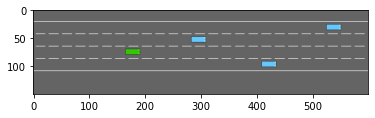

[[ 1.          0.89514065  0.5         0.3125      0.        ]
 [ 1.          0.10668052 -0.25       -0.03208551  0.        ]
 [ 1.          0.22178778  0.25       -0.01961353  0.        ]
 [ 1.          0.32717398 -0.5        -0.03317868  0.        ]
 [ 1.          0.41927984 -0.25       -0.04495154  0.        ]]

Acción: LANE_LEFT -> recommpensa: 0.8222222222222223
Nuevo estado:


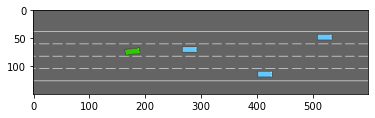

[[ 1.          1.          0.2917827   0.31063917 -0.03405233]
 [ 1.          0.09183487 -0.0417827  -0.04526863  0.03405233]
 [ 1.          0.21475843  0.4582173  -0.01999147  0.03405233]
 [ 1.          0.31217346 -0.2917827  -0.04490376  0.03405233]
 [ 1.          0.4015666  -0.0417827  -0.04738216  0.03405233]]

Acción: IDLE -> recommpensa: 0.8222222222222223
Nuevo estado:


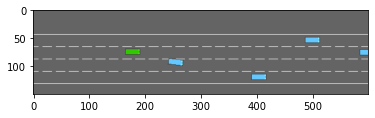

[[ 1.0000000e+00  1.0000000e+00  2.3611753e-01  3.1249997e-01
   1.5479383e-04]
 [ 1.0000000e+00  7.0179000e-02  2.2158255e-01 -5.6389805e-02
   3.3033278e-02]
 [ 1.0000000e+00  2.0503467e-01  5.1388246e-01 -2.7907744e-02
  -1.5479383e-04]
 [ 1.0000000e+00  2.9226649e-01 -2.3611753e-01 -5.3090636e-02
  -1.5479383e-04]
 [ 1.0000000e+00  3.8153464e-01  1.3882481e-02 -5.1509205e-02
  -1.5479383e-04]]

Acción: FASTER -> recommpensa: 0.9327704576054036
Nuevo estado:


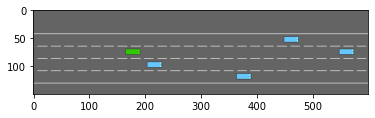

[[ 1.          1.          0.24804774  0.3643145   0.00190538]
 [ 1.          0.03491824  0.26315817 -0.11061559 -0.00125538]
 [ 1.          0.1805535   0.50195223 -0.08339007 -0.00190538]
 [ 1.          0.25784412 -0.24804774 -0.10784467 -0.00190538]
 [ 1.          0.34812024  0.00195226 -0.10453291 -0.00190538]]

Acción: FASTER -> recommpensa: 0.9516618503910704
Nuevo estado:


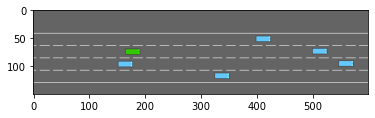

[[ 1.00000000e+00  1.00000000e+00  2.50938594e-01  3.73174816e-01
  -8.87420319e-05]
 [ 1.00000000e+00 -1.22781079e-02  2.51336962e-01 -1.23651154e-01
  -1.49621395e-03]
 [ 1.00000000e+00  1.44624084e-01  4.99061406e-01 -9.43309441e-02
   8.87420319e-05]
 [ 1.00000000e+00  2.12291077e-01 -2.50938594e-01 -1.17915615e-01
   8.87420319e-05]
 [ 1.00000000e+00  3.04025412e-01 -9.38588171e-04 -1.14032902e-01
   8.87420319e-05]]

Acción: IDLE -> recommpensa: 0.9548901671538421
Nuevo estado:


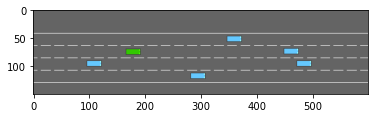

[[ 1.00000000e+00  1.00000000e+00  2.50100404e-01  3.74688089e-01
  -1.13760507e-04]
 [ 1.00000000e+00  1.06269121e-01  4.99899596e-01 -9.71126035e-02
   1.13760507e-04]
 [ 1.00000000e+00  1.64680883e-01 -2.50100404e-01 -1.19726114e-01
   1.13760507e-04]
 [ 1.00000000e+00  2.57976860e-01 -1.00408281e-04 -1.15872711e-01
   1.13760507e-04]
 [ 1.00000000e+00  2.78586686e-01  2.49899596e-01 -1.68851525e-01
   1.13760507e-04]]

Acción: LANE_RIGHT -> recommpensa: 0.9776640707284683
Nuevo estado:


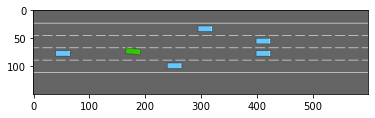

[[ 1.          1.          0.45787078  0.37333745  0.0347012 ]
 [ 1.          0.06816395  0.29212922 -0.09660942 -0.0347012 ]
 [ 1.          0.11772156 -0.45787078 -0.11819056 -0.0347012 ]
 [ 1.          0.2125029  -0.20787078 -0.1146746  -0.0347012 ]
 [ 1.          0.21270204  0.04212922 -0.16334756 -0.0347012 ]]

Acción: FASTER -> recommpensa: 0.9777583465808567
Nuevo estado:


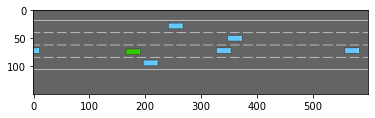

[[ 1.0000000e+00  1.0000000e+00  5.1578081e-01  3.7499022e-01
  -7.1106752e-04]
 [ 1.0000000e+00  2.8866844e-02  2.3421918e-01 -9.8893642e-02
   7.1106752e-04]
 [ 1.0000000e+00  6.9989704e-02 -5.1578081e-01 -1.1941280e-01
   7.1106752e-04]
 [ 1.0000000e+00  1.4767018e-01 -1.5780825e-02 -1.6053008e-01
   7.1106752e-04]
 [ 1.0000000e+00  1.6608986e-01 -2.6578084e-01 -1.1638279e-01
   7.1106752e-04]]

Acción: LANE_RIGHT -> recommpensa: 0.06666666666666665
Nuevo estado:


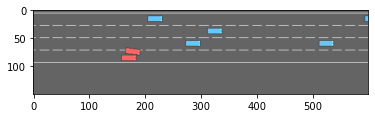

[[ 1.          1.          0.6614428   0.2294816   0.02940652]
 [ 1.         -0.0069299   0.1344332  -0.05931839 -0.02940652]
 [ 1.          0.03558036 -0.6614428   0.02664033 -0.02940652]
 [ 1.          0.09750511 -0.16144282 -0.01087571 -0.02940652]
 [ 1.          0.13279162 -0.41144282  0.02912441 -0.02940652]]
Episodio terminado después de 8 pasos y la recompensa fue 6.505856003570752


In [7]:
obs = env.reset()
t, total_reward, done = 0, 0, False

print("Obs inicial:")
plt.imshow(env.render(mode="rgb_array"))
plt.show()
print(obs)

while not done:
    # Obtener la acción y la ejecutamos
    action = env.action_space.sample()
    new_obs, reward, done, info = env.step(action)
    
    # Imprimimos el paso
    print("\nAcción: {} -> recommpensa: {}".format(env.action_type.actions[action], reward))
    print("Nuevo estado:")
    plt.imshow(env.render(mode="rgb_array"))
    plt.show()
    env.close()
    print(new_obs)
    
    t += 1
    total_reward += reward
    obs = new_obs
    
print("Episodio terminado después de {} pasos y la recompensa fue {}".format(t, total_reward))

<div style="background-color: #grey; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 1.2 (0.5 ptos) - </strong> Explicar los diferentes espacios de observaciones y de acciones:
</div>

Resuelto en el informe

## 2. Agente de referencia

<div style="background-color: #grey; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 2.1 (1.5 ptos) - </strong> Implementar un agente DQN con la observación kinematics
</div>

Lo primero de todo es definir la clase que nos va a permitir crear el replay buffer:

In [8]:
class experienceReplayBuffer:

    def __init__(self, memory_size=50000, burn_in=10000):
        self.memory_size = memory_size
        self.burn_in = burn_in
        self.buffer = namedtuple('Buffer', 
            field_names=['state', 'action', 'reward', 'done', 'next_state'])
        self.replay_memory = deque(maxlen=memory_size)

    def sample_batch(self, batch_size=32):
        samples = np.random.choice(len(self.replay_memory), batch_size, 
                                   replace=False)
        # Use asterisk operator to unpack deque 
        batch = zip(*[self.replay_memory[i] for i in samples])
        return batch

    def append(self, state, action, reward, done, next_state):
        self.replay_memory.append(
            self.buffer(state, action, reward, done, next_state))

    def burn_in_capacity(self):
        return len(self.replay_memory) / self.burn_in

Posteriormente tenemos que crear la red neuronal:

In [9]:
class NeuralNet(torch.nn.Module):  

    def __init__(self, env, learning_rate=1e-3):
        
        """
        Params
        ======
        n_inputs: tamaño del espacio de estadps
        n_outputs: tamaño del espacio de acciones
        actions: array de acciones posibles
        """
        ######################################
        ##TODO: Inicializar parámetros
        super(NeuralNet, self).__init__()
        self.n_inputs = env.observation_space.shape[0] * env.observation_space.shape[1]
        self.n_outputs = env.action_space.n
        self.actions = np.arange(env.action_space.n)
        self.learning_rate = learning_rate
        
        #######################################
        ##TODO: Neural network
        self.model = torch.nn.Sequential(
            torch.nn.Linear(self.n_inputs, 512, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(128, self.n_outputs, bias=True),
        )
        
        #######################################
        ##TODO: Initialize optimizer
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)


    ### e-greedy method
    def get_action(self, state, epsilon=0.05):
        if np.random.random() < epsilon:
            action = np.random.choice(self.actions)  # acción random
        else:
            qvals = self.get_qvals(np.reshape(state, (self.n_inputs,)))  # acción del cálculo de Q para esta acción
            action= torch.max(qvals, dim=-1)[1].item()
        return action
    
    
    def get_qvals(self, state):
        if type(state) is tuple:
            state = np.array([np.ravel(s) for s in state])
        state_t = torch.FloatTensor(state)
        return self.model(state_t)

Luego tenemos que crear el agente:

In [10]:
class DQNAgent:
    
    ######################################
    ##TODO 1: Declarar variables
    def __init__(self, env, main_network, buffer, epsilon=0.1, eps_decay=0.99, batch_size=32):
        
        self.env = env
        self.main_network = main_network
        self.target_network = deepcopy(main_network) 
        self.buffer = buffer
        self.epsilon = epsilon
        self.eps_decay = eps_decay
        self.batch_size = batch_size
        self.nblock = 100 # bloque de los X últimos episodios de los que se calculará la media de recompensas
        self.initialize()
        
    ######################################
    ##TODO 2: Inicializar otras variables necesarias
    def initialize(self):
        self.update_loss = []
        self.training_rewards = []
        self.mean_training_rewards = []
        self.update_position = []
        self.history_loss = []
        self.update_epsilon = []
        self.sync_eps = []
        self.total_reward = 0
        self.step_count = 0
        self.state0 = self.env.reset()
    
    ######################################
    ##TODO 3: Tomar paso siguiente
    def take_step(self, eps, mode='train'):
        if mode == 'explore': 
            action = self.env.action_space.sample()  # acción aleatoria en el burn-in
        else:
            action = self.main_network.get_action(self.state0, eps) # acción a partir del valor de Q (elección de la acción con mejor Q)
            self.step_count += 1
            
        #TODO: tomar 'step' i obtener nuevo estado y recompensa. Guardar la experiencia en el buffer
        new_state, reward, done, _ = self.env.step(action)
        self.total_reward += reward
        self.buffer.append(self.state0, action, reward, done, new_state)
        self.state0 = new_state.copy()
        
        #TODO: resetear entorno 'if done'
        if done:
            self.update_position.append(self.state0[0]) # Guardamos la posición final de cada episodio
            self.state0 = self.env.reset()
        return done

    ## TRAINING
    def train(self, gamma=0.99, max_episodes=50000, 
              batch_size=32,
              dnn_update_frequency=4,
              dnn_sync_frequency=2000):
        
        self.gamma = gamma

        # Rellenamos el buffer con N experiencias aleatorias ()
        print("Filling replay buffer...")
        while self.buffer.burn_in_capacity() < 1:
            self.take_step(self.epsilon, mode='explore')

            
        episode = 0
        training = True
        print("Training...")
        while training:
            self.state0 = self.env.reset()
            self.total_reward = 0
            gamedone = False
            while gamedone == False:
                # El agente toma una acción
                gamedone = self.take_step(self.epsilon, mode='train')
                
                #################################################################################
                #####TODO 4:  Actualizar la red principal según la frecuencia establecida #######
                if self.step_count % dnn_update_frequency == 0:
                    self.update()
                    
                ########################################################################################
                ###TODO 6: Sincronizar red principal y red objetivo según la frecuencia establecida#####
                if self.step_count % dnn_sync_frequency == 0:
                    self.target_network.load_state_dict(
                        self.main_network.state_dict()
                    )
                    self.sync_eps.append(episode)
                
                if gamedone:                   
                    episode += 1
                    
                    # Guardamos la evolución de la pérdida
                    self.history_loss.append(np.mean(self.update_loss))
                        
                    self.update_loss = []
                                    
                    #######################################################################################
                    ###TODO 7: calcular la media de recompensa de los últimos X episodios, y almacenar
                    self.training_rewards.append(self.total_reward)
                    mean_rewards = np.mean(
                        self.training_rewards[-self.nblock:]
                    )
                    self.mean_training_rewards.append(mean_rewards)

                    self.update_epsilon.append(self.epsilon) # Guardamos la evolución de epsilon
                    
                    print("\rEpisode {:d} Mean Rewards {:.2f} Epsilon {}\t\t".format(
                        episode, mean_rewards, self.epsilon), end="")
                    
                    #######################################################################################
                    ### TODO 8: Comprobar que todavía quedan episodios. Parar el aprendizaje si se llega al límite
                    if episode >= max_episodes:
                        training = False
                        print('\nEpisode limit reached')
                        break
                    
                    #################################################################################
                    ######TODO 9: Actualizar epsilon según la velocidad de decaimiento fijada########
                    self.epsilon = max(self.epsilon * self.eps_decay, 0.01)

                    
    #####################################         
    #####TODO 5: cálculo de la pérdida###
    def calculate_loss(self, batch):
        # Separamos las variables de la experiencia y las convertimos a tensores 
        states, actions, rewards, dones, next_states = [i for i in batch] 
        rewards_vals = torch.FloatTensor(rewards)
        actions_vals = torch.LongTensor(np.array(actions)).reshape(-1,1)
        dones_t = torch.ByteTensor(dones)
        
        # Obtenemos los valores de Q de la red principal
        qvals = torch.gather(self.main_network.get_qvals(states), 1, actions_vals)
        # Obtenemos los valores de Q objetivo. El parámetro detach() evita que estos valores actualicen la red objetivo
        qvals_next = torch.max(self.target_network.get_qvals(next_states),
                               dim=-1)[0].detach()
        qvals_next[dones_t] = 0 # 0 en estados terminales
        
        #################################################################################
        ### TODO: Calcular ecuación de Bellman
        expected_qvals = self.gamma * qvals_next + rewards_vals
        
        #################################################################################
        ### TODO: Calcular la pérdida (MSE)
        loss = torch.nn.MSELoss()(qvals, expected_qvals.reshape(-1,1))
        
        return loss

    
    def update(self):
        self.main_network.optimizer.zero_grad()  # eliminamos cualquier gradiente pasado
        batch = self.buffer.sample_batch(batch_size=self.batch_size) # seleccionamos un conjunto del buffer
        loss = self.calculate_loss(batch) # calculamos la pérdida
        loss.backward() # hacemos la diferencia para obtener los gradientes
        self.main_network.optimizer.step() # aplicamos los gradientes a la red neuronal
        # Guardamos los valores de pérdida
        self.update_loss.append(loss.detach().numpy())
        
    def plot_rewards(self):
        plt.figure(figsize=(12,8))
        plt.plot(self.training_rewards, label='Rewards')
        plt.plot(self.mean_training_rewards, label='Mean Rewards')
        plt.title("Evolución de las recompensas")
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.legend(loc="upper left")
        plt.show()
        
    def plot_loss(self):
        plt.figure(figsize=(12,8))
        plt.plot(self.history_loss)
        plt.title("Evolución de la pérdida")
        plt.xlabel('Episode')
        plt.ylabel('Loss')
        plt.show()
        
    def plot_epsilon(self):
        plt.figure(figsize=(12,8))
        plt.plot(self.update_epsilon)
        plt.title("Evolución de epsilon")
        plt.xlabel('Episode')
        plt.ylabel('Epsilon')
        plt.show()

<div style="background-color: #grey; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 2.2 (1 ptos) - </strong> Entrenar el agente y buscar los hiperparámetros óptimos:
</div>

In [32]:
# Definición de los hiperparámetros

# lr = 0.001            # Velocidad de aprendizaje
# BATCH_SIZE = 32       # Tamaño del batch
# MAX_EPISODES = 1500   # Número de episodios
# BURN_IN = 100        # Número de episodios para rellenar el buffer
# DNN_UPD = 3           # Frecuencia de actualización de la red neuronal
# DNN_SYNC = 1000       # Frecuencia de sincronización con la red objetivo
# MEMORY_SIZE = 10000   # Capacidad máxima del buffer
# GAMMA = 0.99          # Factor de descuento
# EPSILON = 1           # Epsilon
# EPSILON_DECAY = 0.99   # Decaimiento de epsilon

# lr = 0.001            # Velocidad de aprendizaje
# BATCH_SIZE = 32       # Tamaño del batch
# MAX_EPISODES = 5000   # Número de episodios
# BURN_IN = 1        # Número de episodios para rellenar el buffer
# DNN_UPD = 3           # Frecuencia de actualización de la red neuronal
# DNN_SYNC = 1000       # Frecuencia de sincronización con la red objetivo
# MEMORY_SIZE = 10   # Capacidad máxima del buffer
# GAMMA = 0.99          # Factor de descuento
# EPSILON = 0.01           # Epsilon
# EPSILON_DECAY = 0.99   # Decaimiento de epsilon

# lr = 0.001            # Velocidad de aprendizaje
# BATCH_SIZE = 32       # Tamaño del batch
# MAX_EPISODES = 4000   # Número de episodios
# BURN_IN = 1000        # Número de episodios para rellenar el buffer
# DNN_UPD = 3           # Frecuencia de actualización de la red neuronal
# DNN_SYNC = 500       # Frecuencia de sincronización con la red objetivo
# MEMORY_SIZE = 10000   # Capacidad máxima del buffer
# GAMMA = 0.8          # Factor de descuento
# EPSILON = 1           # Epsilon
# EPSILON_DECAY = 0.99   # Decaimiento de epsilon

lr = 0.001            # Velocidad de aprendizaje
BATCH_SIZE = 32      # Tamaño del batch
MAX_EPISODES = 1500   # Número de episodios
BURN_IN = 1000        # Número de episodios para rellenar el buffer
DNN_UPD = 3           # Frecuencia de actualización de la red neuronal
DNN_SYNC = 50      # Frecuencia de sincronización con la red objetivo
MEMORY_SIZE = 10000   # Capacidad máxima del buffer
GAMMA = 0.8          # Factor de descuento
EPSILON = 1           # Epsilon
EPSILON_DECAY = 0.99   # Decaimiento de epsilon

In [33]:
# Carga de la red neuronal
dqn = NeuralNet(env, learning_rate=lr)

# Creación del buffer
buffer = experienceReplayBuffer(
    memory_size=MEMORY_SIZE, 
    burn_in=BURN_IN
)

# Creación del agente
agent_dqn = DQNAgent(
    env=env,
    main_network=dqn,
    buffer=buffer,
    epsilon=EPSILON,
    eps_decay=EPSILON_DECAY,
    batch_size=BATCH_SIZE
)

# Entrenamos el agente
agent_dqn.train(
    gamma=GAMMA, 
    max_episodes=MAX_EPISODES, 
    batch_size=BATCH_SIZE,  
    dnn_update_frequency=DNN_UPD, 
    dnn_sync_frequency=DNN_SYNC
)

Filling replay buffer...
Training...


<ipython-input-10-7b9067ae957f>:137: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:1273.)
  qvals_next[dones_t] = 0 # 0 en estados terminales


Episode 600 Mean Rewards 21.51 Epsilon 0.01		2118606165716			
Episode limit reached


In [34]:
# Guardamos el modelo entrenado
trained_model = {
    "state_dic" : agent_dqn.main_network.state_dict()
}
torch.save(trained_model, "DQN.pth")

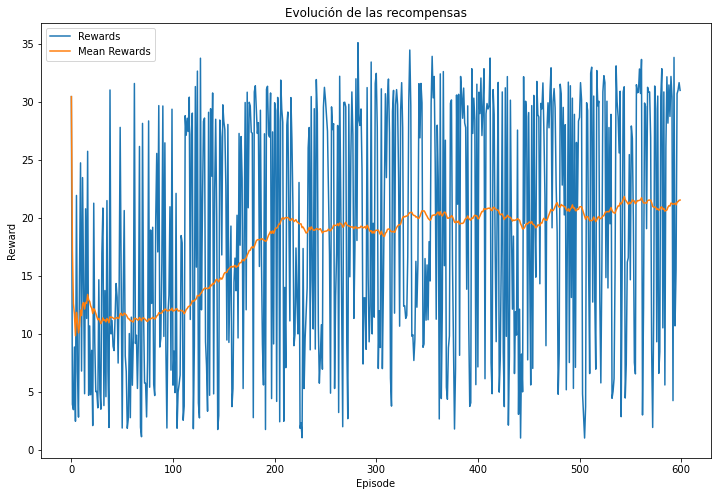

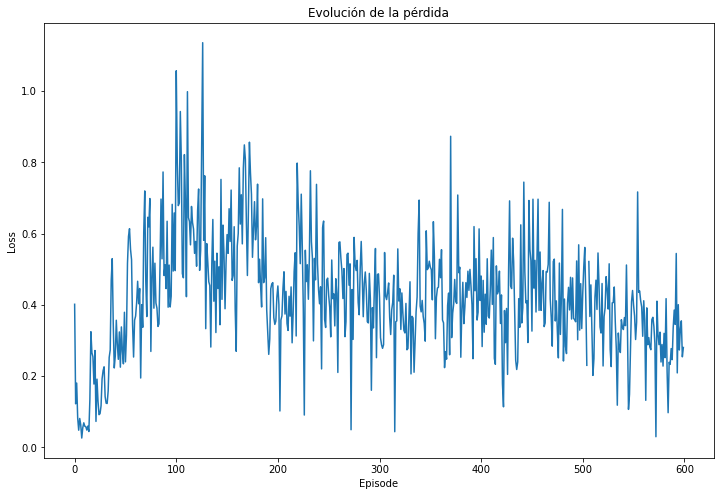

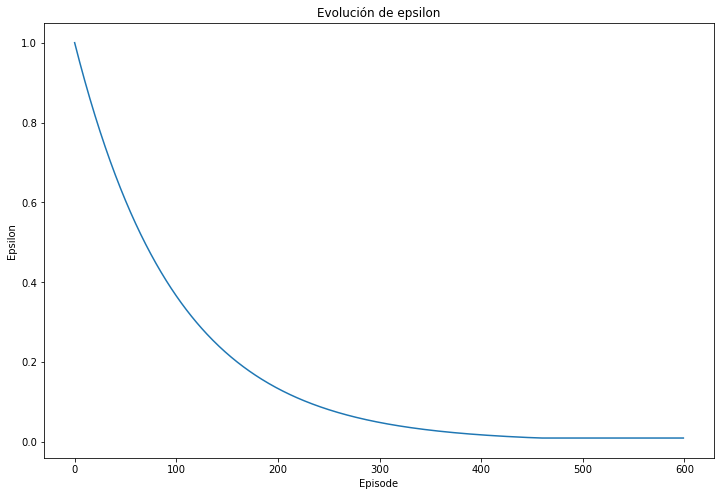

In [35]:
agent_dqn.plot_rewards()
agent_dqn.plot_loss()
agent_dqn.plot_epsilon()

Obs inicial:


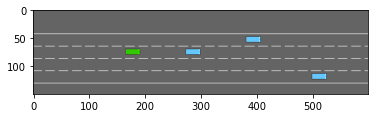

[[ 1.          0.9009574   0.25        0.3125      0.        ]
 [ 1.          0.09805359  0.         -0.02222465  0.        ]
 [ 1.          0.19635963 -0.25       -0.02095963  0.        ]
 [ 1.          0.303394    0.5        -0.01630208  0.        ]
 [ 1.          0.40692297  0.         -0.03210894  0.        ]]

Acción: SLOWER -> recommpensa: 0.7116739868390409
Nuevo estado:


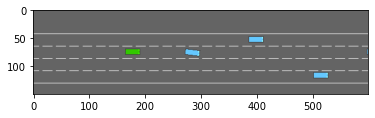

[[ 1.          1.          0.25        0.26068053  0.        ]
 [ 1.          0.09746407  0.03296605  0.00532641  0.03393734]
 [ 1.          0.20029294 -0.25        0.02962172  0.        ]
 [ 1.          0.3060815   0.4831584   0.01957988 -0.00295421]
 [ 1.          0.392923    0.         -0.04870978  0.        ]]

Acción: SLOWER -> recommpensa: 0.6927825940533742
Nuevo estado:


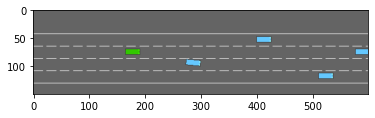

[[ 1.          1.          0.25        0.25182518  0.        ]
 [ 1.          0.09877407  0.23148431  0.00779308  0.02412334]
 [ 1.          0.21302858 -0.25        0.03252029  0.        ]
 [ 1.          0.31402084  0.49536932  0.01786639  0.00271503]
 [ 1.          0.37394056  0.         -0.03900058  0.        ]]

Acción: SLOWER -> recommpensa: 0.6895542772906024
Nuevo estado:


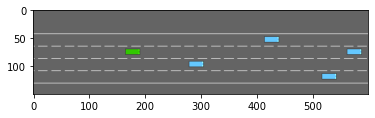

[[ 1.0000000e+00  1.0000000e+00  2.5000000e-01  2.5031191e-01
   0.0000000e+00]
 [ 1.0000000e+00  1.0302504e-01  2.6052293e-01  1.2370930e-02
  -1.2082077e-03]
 [ 1.0000000e+00  2.2599967e-01 -2.5000000e-01  3.1970199e-02
   0.0000000e+00]
 [ 1.0000000e+00  3.1994343e-01  5.0073189e-01  1.1323214e-02
   1.9995600e-04]
 [ 1.0000000e+00  3.6062989e-01  0.0000000e+00 -2.7922107e-02
   0.0000000e+00]]

Acción: SLOWER -> recommpensa: 0.6890025959381983
Nuevo estado:


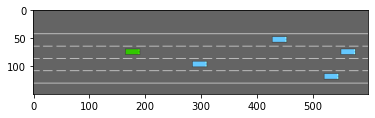

[[ 1.00000000e+00  1.00000000e+00  2.50000000e-01  2.50053287e-01
   0.00000000e+00]
 [ 1.00000000e+00  1.08332425e-01  2.51087785e-01  1.41476709e-02
  -1.22750236e-03]
 [ 1.00000000e+00  2.39058763e-01 -2.50000000e-01  3.34268734e-02
   0.00000000e+00]
 [ 1.00000000e+00  3.23412895e-01  5.00237346e-01  5.95584931e-03
  -1.27705105e-04]
 [ 1.00000000e+00  3.50646734e-01  0.00000000e+00 -2.22175326e-02
   0.00000000e+00]]

Acción: SLOWER -> recommpensa: 0.6889083200858099
Nuevo estado:


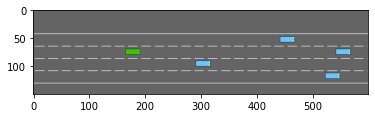

[[ 1.00000000e+00  1.00000000e+00  2.50000000e-01  2.50009120e-01
   0.00000000e+00]
 [ 1.00000000e+00  1.14222616e-01  2.49485984e-01  1.53037738e-02
   4.33122696e-05]
 [ 1.00000000e+00  2.51287907e-01 -2.50000000e-01  2.41992027e-02
   0.00000000e+00]
 [ 1.00000000e+00  3.25055957e-01  4.99969959e-01  2.27020355e-03
  -1.25628949e-05]
 [ 1.00000000e+00  3.42341304e-01  0.00000000e+00 -1.77306626e-02
   0.00000000e+00]]

Acción: SLOWER -> recommpensa: 0.6888922094518275
Nuevo estado:


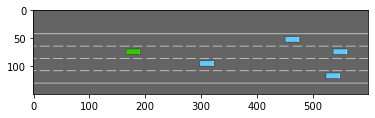

[[ 1.0000000e+00  1.0000000e+00  2.5000000e-01  2.5000155e-01
   0.0000000e+00]
 [ 1.0000000e+00  1.2050060e-01  2.4993786e-01  1.6088184e-02
   6.2360567e-05]
 [ 1.0000000e+00  2.5939798e-01 -2.5000000e-01  1.6844971e-02
   0.0000000e+00]
 [ 1.0000000e+00  3.2548892e-01  4.9998799e-01 -7.2069954e-05
   5.8547207e-06]
 [ 1.0000000e+00  3.3784860e-01  0.0000000e+00 -4.6600248e-03
   0.0000000e+00]]

Acción: SLOWER -> recommpensa: 0.6888894563340274
Nuevo estado:


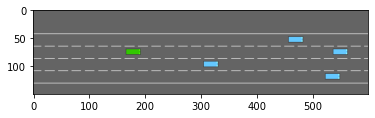

[[ 1.0000000e+00  1.0000000e+00  2.5000000e-01  2.5000027e-01
   0.0000000e+00]
 [ 1.0000000e+00  1.2704144e-01  2.5002503e-01  1.6615463e-02
  -1.3147012e-06]
 [ 1.0000000e+00  2.6543018e-01 -2.5000000e-01  1.3531492e-02
   0.0000000e+00]
 [ 1.0000000e+00  3.2517630e-01  5.0000119e-01 -1.4506025e-03
   7.3976150e-07]
 [ 1.0000000e+00  3.3775371e-01  0.0000000e+00  4.1664923e-03
   0.0000000e+00]]

Acción: SLOWER -> recommpensa: 0.6888889858585868
Nuevo estado:


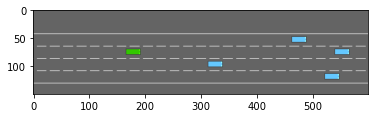

[[ 1.0000000e+00  1.0000000e+00  2.5000000e-01  2.5000006e-01
   0.0000000e+00]
 [ 1.0000000e+00  1.3375714e-01  2.5000349e-01  1.6961129e-02
  -3.1596037e-06]
 [ 1.0000000e+00  2.7053320e-01 -2.5000000e-01  1.2095615e-02
   0.0000000e+00]
 [ 1.0000000e+00  3.2444450e-01  5.0000060e-01 -2.1669257e-03
  -2.6371669e-07]
 [ 1.0000000e+00  3.4057453e-01  0.0000000e+00  9.8949037e-03
   0.0000000e+00]]

Acción: SLOWER -> recommpensa: 0.6888889054598694
Nuevo estado:


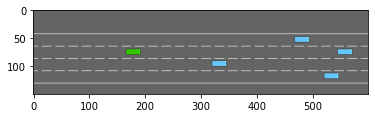

[[ 1.0000000e+00  1.0000000e+00  2.5000000e-01  2.5000000e-01
   0.0000000e+00]
 [ 1.0000000e+00  1.4058603e-01  2.4999879e-01  1.7180720e-02
   2.2588896e-08]
 [ 1.0000000e+00  2.7524826e-01 -2.5000000e-01  1.1536128e-02
   0.0000000e+00]
 [ 1.0000000e+00  3.2351467e-01  4.9999997e-01 -2.4419525e-03
  -4.1607780e-08]
 [ 1.0000000e+00  3.4526464e-01  0.0000000e+00  1.3516914e-02
   0.0000000e+00]]

Acción: SLOWER -> recommpensa: 0.6888888917206746
Nuevo estado:


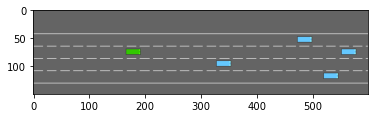

[[ 1.0000000e+00  1.0000000e+00  2.5000000e-01  2.5000000e-01
   0.0000000e+00]
 [ 1.0000000e+00  1.4748555e-01  2.4999981e-01  1.7314132e-02
   1.5954342e-07]
 [ 1.0000000e+00  2.7982196e-01 -2.5000000e-01  1.1359030e-02
   0.0000000e+00]
 [ 1.0000000e+00  3.2253236e-01  4.9999997e-01 -2.4319221e-03
   1.1705422e-08]
 [ 1.0000000e+00  3.5112822e-01  0.0000000e+00  1.5773019e-02
   0.0000000e+00]]

Acción: SLOWER -> recommpensa: 0.6888888893728078
Nuevo estado:


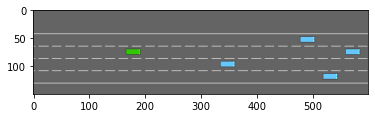

[[ 1.0000000e+00  1.0000000e+00  2.5000000e-01  2.5000000e-01
   0.0000000e+00]
 [ 1.0000000e+00  1.5442678e-01  2.5000006e-01  1.7389040e-02
   1.0653360e-09]
 [ 1.0000000e+00  2.8435725e-01 -2.5000000e-01  1.1328221e-02
   0.0000000e+00]
 [ 1.0000000e+00  3.2159004e-01  5.0000000e-01 -2.2447787e-03
   2.2660354e-09]
 [ 1.0000000e+00  3.5772026e-01  0.0000000e+00  1.7169328e-02
   0.0000000e+00]]

Acción: SLOWER -> recommpensa: 0.6888888889715848
Nuevo estado:


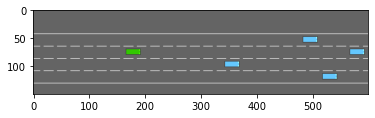

[[ 1.0000000e+00  1.0000000e+00  2.5000000e-01  2.5000000e-01
   0.0000000e+00]
 [ 1.0000000e+00  1.6139002e-01  2.5000000e-01  1.7424101e-02
  -8.0261646e-09]
 [ 1.0000000e+00  2.8888994e-01 -2.5000000e-01  1.1337640e-02
   0.0000000e+00]
 [ 1.0000000e+00  3.2074392e-01  5.0000000e-01 -1.9537068e-03
  -5.1189664e-10]
 [ 1.0000000e+00  3.6476299e-01  0.0000000e+00  1.8033745e-02
   0.0000000e+00]]

Acción: SLOWER -> recommpensa: 0.6888888889030206
Nuevo estado:


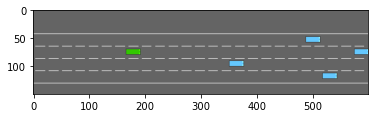

[[ 1.0000000e+00  1.0000000e+00  2.5000000e-01  2.5000000e-01
   0.0000000e+00]
 [ 1.0000000e+00  1.6836183e-01  2.5000000e-01  1.7431621e-02
  -1.6472212e-10]
 [ 1.0000000e+00  2.9342669e-01 -2.5000000e-01  1.1344596e-02
   0.0000000e+00]
 [ 1.0000000e+00  3.2002586e-01  5.0000000e-01 -1.6075200e-03
  -1.2055312e-10]
 [ 1.0000000e+00  3.7208530e-01  0.0000000e+00  1.8572001e-02
   0.0000000e+00]]

Acción: SLOWER -> recommpensa: 0.6888888888913037
Nuevo estado:


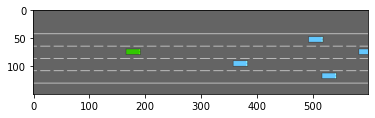

[[ 1.0000000e+00  1.0000000e+00  2.5000000e-01  2.5000000e-01
   0.0000000e+00]
 [ 1.0000000e+00  1.7533278e-01  2.5000000e-01  1.7419608e-02
   4.0219539e-10]
 [ 1.0000000e+00  2.9796347e-01 -2.5000000e-01  1.1335618e-02
   0.0000000e+00]
 [ 1.0000000e+00  3.1945139e-01  5.0000000e-01 -1.2382894e-03
   2.2003288e-11]
 [ 1.0000000e+00  3.7958241e-01  0.0000000e+00  1.8910427e-02
   0.0000000e+00]]

Acción: SLOWER -> recommpensa: 0.6888888888893016
Nuevo estado:


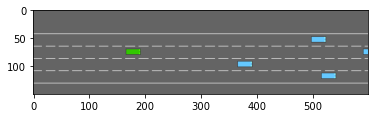

[[ 1.00000000e+00  1.00000000e+00  2.50000000e-01  2.50000000e-01
   0.00000000e+00]
 [ 1.00000000e+00  1.82296112e-01  2.50000000e-01  1.73931215e-02
   1.38780099e-11]
 [ 1.00000000e+00  3.02493364e-01 -2.50000000e-01  1.13095585e-02
   0.00000000e+00]
 [ 1.00000000e+00  3.19025606e-01  5.00000000e-01 -8.66749615e-04
   6.29962749e-12]
 [ 1.00000000e+00  3.87189925e-01  0.00000000e+00  1.91254839e-02
   0.00000000e+00]]

Acción: SLOWER -> recommpensa: 0.6888888888889594
Nuevo estado:


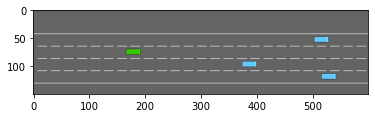

[[ 1.0000000e+00  1.0000000e+00  2.5000000e-01  2.5000000e-01
   0.0000000e+00]
 [ 1.0000000e+00  1.8924662e-01  2.5000000e-01  1.7355170e-02
  -2.0072166e-11]
 [ 1.0000000e+00  3.0701011e-01 -2.5000000e-01  1.1269632e-02
   0.0000000e+00]
 [ 1.0000000e+00  3.1874678e-01  5.0000000e-01 -5.0589605e-04
  -9.2548191e-13]
 [ 1.0000000e+00  3.9486784e-01  0.0000000e+00  1.9263132e-02
   0.0000000e+00]]

Acción: SLOWER -> recommpensa: 0.688888888888901
Nuevo estado:


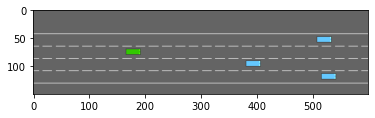

[[ 1.0000000e+00  1.0000000e+00  2.5000000e-01  2.5000000e-01
   0.0000000e+00]
 [ 1.0000000e+00  1.9618009e-01  2.5000000e-01  1.7307505e-02
  -9.7843955e-13]
 [ 1.0000000e+00  3.1150895e-01 -2.5000000e-01  1.1219931e-02
   0.0000000e+00]
 [ 1.0000000e+00  3.1860906e-01  5.0000000e-01 -1.6330194e-04
  -3.2451819e-13]
 [ 1.0000000e+00  4.0259081e-01  0.0000000e+00  1.9350925e-02
   0.0000000e+00]]

Acción: SLOWER -> recommpensa: 0.688888888888891
Nuevo estado:


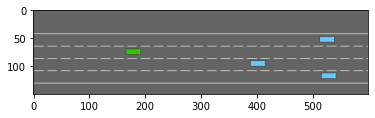

[[ 1.0000000e+00  1.0000000e+00  2.5000000e-01  2.5000000e-01
   0.0000000e+00]
 [ 1.0000000e+00  2.0309284e-01  2.5000000e-01  1.7251156e-02
   9.9742437e-13]
 [ 1.0000000e+00  3.1598666e-01 -2.5000000e-01  1.1164088e-02
   0.0000000e+00]
 [ 1.0000000e+00  3.1860435e-01  5.0000000e-01  1.5722308e-04
   3.7747583e-14]
 [ 1.0000000e+00  4.1034225e-01  0.0000000e+00  1.9405404e-02
   0.0000000e+00]]

Acción: SLOWER -> recommpensa: 0.6888888888888892
Nuevo estado:


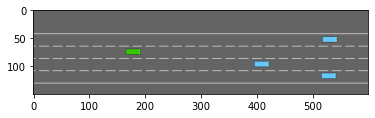

[[ 1.0000000e+00  1.0000000e+00  2.5000000e-01  2.5000000e-01
   0.0000000e+00]
 [ 1.0000000e+00  2.0998155e-01  2.5000000e-01  1.7186750e-02
   6.3282712e-14]
 [ 1.0000000e+00  3.1872347e-01  5.0000000e-01  4.5437340e-04
   1.6431301e-14]
 [ 1.0000000e+00  3.2044134e-01 -2.5000000e-01  1.1104908e-02
   0.0000000e+00]
 [ 1.0000000e+00  4.1811088e-01  0.0000000e+00  1.9436501e-02
   0.0000000e+00]]

Acción: SLOWER -> recommpensa: 0.6888888888888892
Nuevo estado:


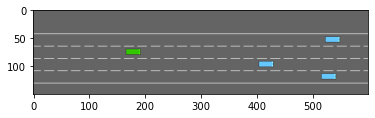

[[ 1.0000000e+00  1.0000000e+00  2.5000000e-01  2.5000000e-01
   0.0000000e+00]
 [ 1.0000000e+00  2.1684304e-01  2.5000000e-01  1.7114684e-02
  -4.9404925e-14]
 [ 1.0000000e+00  3.1895712e-01  5.0000000e-01  7.2841492e-04
  -1.4432899e-15]
 [ 1.0000000e+00  3.2487202e-01 -2.5000000e-01  1.1044387e-02
   0.0000000e+00]
 [ 1.0000000e+00  4.2588854e-01  0.0000000e+00  1.9450206e-02
   0.0000000e+00]]

Acción: SLOWER -> recommpensa: 0.6888888888888892
Nuevo estado:


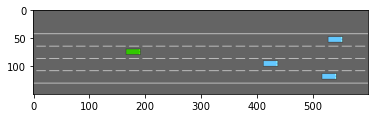

[[ 1.0000000e+00  1.0000000e+00  2.5000000e-01  2.5000000e-01
   0.0000000e+00]
 [ 1.0000000e+00  2.2367433e-01  2.5000000e-01  1.7035209e-02
  -3.8857806e-15]
 [ 1.0000000e+00  3.1929627e-01  5.0000000e-01  9.8053017e-04
  -8.8817842e-16]
 [ 1.0000000e+00  3.2927844e-01 -2.5000000e-01  1.0983864e-02
   0.0000000e+00]
 [ 1.0000000e+00  4.3366903e-01  0.0000000e+00  1.9450128e-02
   0.0000000e+00]]

Acción: SLOWER -> recommpensa: 0.6888888888888892
Nuevo estado:


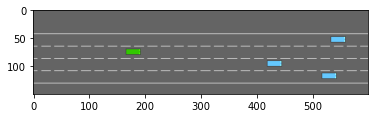

[[ 1.0000000e+00  1.0000000e+00  2.5000000e-01  2.5000000e-01
   0.0000000e+00]
 [ 1.0000000e+00  2.3047246e-01  2.5000000e-01  1.6948482e-02
   2.4424907e-15]
 [ 1.0000000e+00  3.1973240e-01  5.0000000e-01  1.2123841e-03
   0.0000000e+00]
 [ 1.0000000e+00  3.3366081e-01 -2.5000000e-01  1.0924188e-02
   0.0000000e+00]
 [ 1.0000000e+00  4.4144726e-01  0.0000000e+00  1.9438447e-02
   0.0000000e+00]]

Acción: SLOWER -> recommpensa: 0.6888888888888892
Nuevo estado:


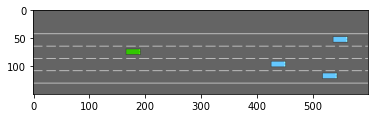

[[ 1.0000000e+00  1.0000000e+00  2.5000000e-01  2.5000000e-01
   0.0000000e+00]
 [ 1.0000000e+00  2.3723456e-01  2.5000000e-01  1.6854601e-02
   2.2204460e-16]
 [ 1.0000000e+00  3.2025778e-01  5.0000000e-01  1.4258516e-03
   2.2204460e-16]
 [ 1.0000000e+00  3.3801955e-01 -2.5000000e-01  1.0865867e-02
   0.0000000e+00]
 [ 1.0000000e+00  4.4921887e-01  0.0000000e+00  1.9416489e-02
   0.0000000e+00]]

Acción: SLOWER -> recommpensa: 0.6888888888888892
Nuevo estado:


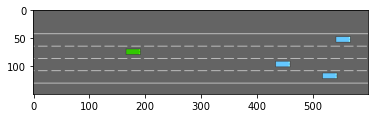

[[ 1.0000000e+00  1.0000000e+00  2.5000000e-01  2.5000000e-01
   0.0000000e+00]
 [ 1.0000000e+00  2.4395779e-01  2.5000000e-01  1.6753612e-02
  -2.2204460e-16]
 [ 1.0000000e+00  3.2086539e-01  5.0000000e-01  1.6228560e-03
   2.2204460e-16]
 [ 1.0000000e+00  3.4235525e-01 -2.5000000e-01  1.0809170e-02
   0.0000000e+00]
 [ 1.0000000e+00  4.5697990e-01  0.0000000e+00  1.9385051e-02
   0.0000000e+00]]

Acción: SLOWER -> recommpensa: 0.6888888888888892
Nuevo estado:


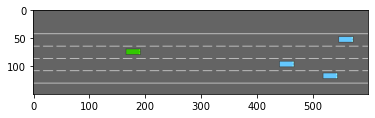

[[ 1.0000000e+00  1.0000000e+00  2.5000000e-01  2.5000000e-01
   0.0000000e+00]
 [ 1.0000000e+00  2.5063929e-01  2.5000000e-01  1.6645536e-02
  -2.2204460e-16]
 [ 1.0000000e+00  3.2154906e-01  5.0000000e-01  1.8052772e-03
   2.2204460e-16]
 [ 1.0000000e+00  3.4666860e-01 -2.5000000e-01  1.0754216e-02
   0.0000000e+00]
 [ 1.0000000e+00  4.6472666e-01  0.0000000e+00  1.9344622e-02
   0.0000000e+00]]

Acción: SLOWER -> recommpensa: 0.6888888888888892
Nuevo estado:


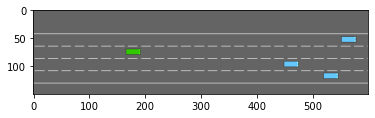

[[ 1.0000000e+00  1.0000000e+00  2.5000000e-01  2.5000000e-01
   0.0000000e+00]
 [ 1.0000000e+00  2.5727624e-01  2.5000000e-01  1.6530367e-02
  -2.2204460e-16]
 [ 1.0000000e+00  3.2230324e-01  5.0000000e-01  1.9749040e-03
   2.2204460e-16]
 [ 1.0000000e+00  3.5096031e-01 -2.5000000e-01  1.0701022e-02
   0.0000000e+00]
 [ 1.0000000e+00  4.7245562e-01  0.0000000e+00  1.9295510e-02
   0.0000000e+00]]

Acción: SLOWER -> recommpensa: 0.6888888888888892
Nuevo estado:


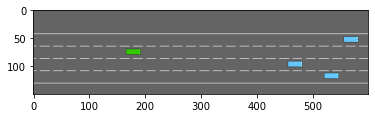

[[ 1.0000000e+00  1.0000000e+00  2.5000000e-01  2.5000000e-01
   0.0000000e+00]
 [ 1.0000000e+00  2.6386580e-01  2.5000000e-01  1.6408093e-02
  -2.2204460e-16]
 [ 1.0000000e+00  3.2312313e-01  5.0000000e-01  2.1334100e-03
   2.2204460e-16]
 [ 1.0000000e+00  3.5523105e-01 -2.5000000e-01  1.0649543e-02
   0.0000000e+00]
 [ 1.0000000e+00  4.8016337e-01  0.0000000e+00  1.9237908e-02
   0.0000000e+00]]

Acción: SLOWER -> recommpensa: 0.6888888888888892
Nuevo estado:


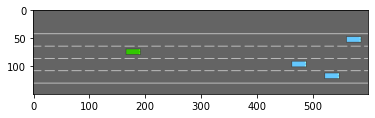

[[ 1.0000000e+00  1.0000000e+00  2.5000000e-01  2.5000000e-01
   0.0000000e+00]
 [ 1.0000000e+00  2.7040511e-01  2.5000000e-01  1.6278693e-02
  -2.2204460e-16]
 [ 1.0000000e+00  3.2400456e-01  5.0000000e-01  2.2823429e-03
   2.2204460e-16]
 [ 1.0000000e+00  3.5948151e-01 -2.5000000e-01  1.0599699e-02
   0.0000000e+00]
 [ 1.0000000e+00  4.8784646e-01  0.0000000e+00  1.9171949e-02
   0.0000000e+00]]

Acción: SLOWER -> recommpensa: 0.6888888888888892
Nuevo estado:


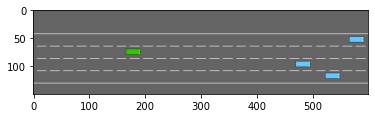

[[ 1.00000000e+00  1.00000000e+00  2.50000000e-01  2.50000000e-01
   0.00000000e+00]
 [ 1.00000000e+00  2.76891351e-01  2.50000000e-01  1.61421429e-02
  -2.22044605e-16]
 [ 1.00000000e+00  3.24944049e-01  5.00000000e-01  2.42312253e-03
   2.22044605e-16]
 [ 1.00000000e+00  3.63712341e-01 -2.50000000e-01  1.05513865e-02
   0.00000000e+00]
 [ 1.00000000e+00  4.95501667e-01  0.00000000e+00  1.90977398e-02
   0.00000000e+00]]

Acción: SLOWER -> recommpensa: 0.6888888888888892
Nuevo estado:


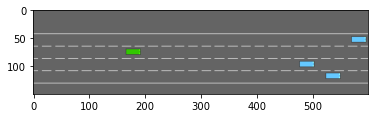

[[ 1.0000000e+00  1.0000000e+00  2.5000000e-01  2.5000000e-01
   0.0000000e+00]
 [ 1.0000000e+00  2.8332162e-01  2.5000000e-01  1.5998423e-02
  -2.2204460e-16]
 [ 1.0000000e+00  3.2593849e-01  5.0000000e-01  2.5570411e-03
   2.2204460e-16]
 [ 1.0000000e+00  3.6792409e-01 -2.5000000e-01  1.0504491e-02
   0.0000000e+00]
 [ 1.0000000e+00  5.0312567e-01  0.0000000e+00  1.9015368e-02
   0.0000000e+00]]

Acción: SLOWER -> recommpensa: 0.6888888888888892
Nuevo estado:


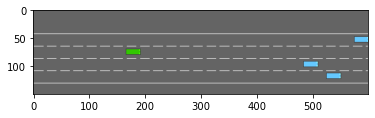

[[ 1.0000000e+00  1.0000000e+00  2.5000000e-01  2.5000000e-01
   0.0000000e+00]
 [ 1.0000000e+00  2.8969306e-01  2.5000000e-01  1.5847521e-02
  -2.2204460e-16]
 [ 1.0000000e+00  3.2698542e-01  5.0000000e-01  2.6852658e-03
   2.2204460e-16]
 [ 1.0000000e+00  3.7211734e-01 -2.5000000e-01  1.0458893e-02
   0.0000000e+00]
 [ 1.0000000e+00  5.1071519e-01  0.0000000e+00  1.8924920e-02
   0.0000000e+00]]

Acción: SLOWER -> recommpensa: 0.6888888888888892
Nuevo estado:


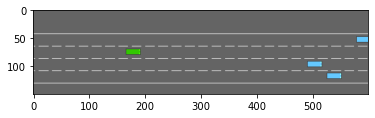

[[ 1.0000000e+00  1.0000000e+00  2.5000000e-01  2.5000000e-01
   0.0000000e+00]
 [ 1.0000000e+00  2.9600281e-01  2.5000000e-01  1.5689429e-02
  -2.2204460e-16]
 [ 1.0000000e+00  3.2808274e-01  5.0000000e-01  2.8088433e-03
   2.2204460e-16]
 [ 1.0000000e+00  3.7629256e-01 -2.5000000e-01  1.0414476e-02
   0.0000000e+00]
 [ 1.0000000e+00  5.1826704e-01  0.0000000e+00  1.8826490e-02
   0.0000000e+00]]

Acción: SLOWER -> recommpensa: 0.6888888888888892
Nuevo estado:


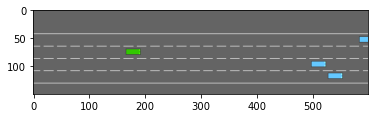

[[ 1.0000000e+00  1.0000000e+00  2.5000000e-01  2.5000000e-01
   0.0000000e+00]
 [ 1.0000000e+00  3.0224794e-01  2.5000000e-01  1.5524154e-02
  -2.2204460e-16]
 [ 1.0000000e+00  3.2922876e-01  5.0000000e-01  2.9287047e-03
   2.2204460e-16]
 [ 1.0000000e+00  3.8045022e-01 -2.5000000e-01  1.0371120e-02
   0.0000000e+00]
 [ 1.0000000e+00  5.2577806e-01  0.0000000e+00  1.8720180e-02
   0.0000000e+00]]

Acción: SLOWER -> recommpensa: 0.6888888888888892
Nuevo estado:


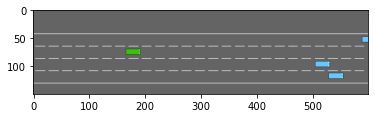

[[ 1.0000000e+00  1.0000000e+00  2.5000000e-01  2.5000000e-01
   0.0000000e+00]
 [ 1.0000000e+00  3.0842566e-01  2.5000000e-01  1.5351712e-02
  -2.2204460e-16]
 [ 1.0000000e+00  3.3042216e-01  5.0000000e-01  3.0456716e-03
   2.2204460e-16]
 [ 1.0000000e+00  3.8459072e-01 -2.5000000e-01  1.0328711e-02
   0.0000000e+00]
 [ 1.0000000e+00  5.3324509e-01  0.0000000e+00  1.8606102e-02
   0.0000000e+00]]

Acción: SLOWER -> recommpensa: 0.6888888888888892
Nuevo estado:


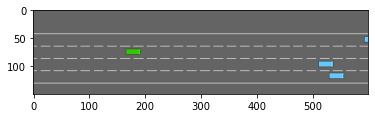

[[ 1.0000000e+00  1.0000000e+00  2.5000000e-01  2.5000000e-01
   0.0000000e+00]
 [ 1.0000000e+00  3.1453305e-01  2.5000000e-01  1.5172136e-02
  -2.2204460e-16]
 [ 1.0000000e+00  3.3166191e-01  5.0000000e-01  3.1604618e-03
   2.2204460e-16]
 [ 1.0000000e+00  3.8871443e-01 -2.5000000e-01  1.0287140e-02
   0.0000000e+00]
 [ 1.0000000e+00  5.4066509e-01  0.0000000e+00  1.8484388e-02
   0.0000000e+00]]

Acción: SLOWER -> recommpensa: 0.6888888888888892
Nuevo estado:


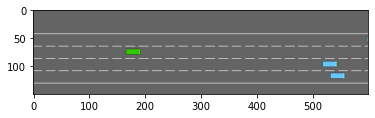

[[ 1.0000000e+00  1.0000000e+00  2.5000000e-01  2.5000000e-01
   0.0000000e+00]
 [ 1.0000000e+00  3.2056731e-01  2.5000000e-01  1.4985475e-02
  -2.2204460e-16]
 [ 1.0000000e+00  3.3294728e-01  5.0000000e-01  3.2736957e-03
   2.2204460e-16]
 [ 1.0000000e+00  3.9282164e-01 -2.5000000e-01  1.0246300e-02
   0.0000000e+00]
 [ 1.0000000e+00  5.4803497e-01  0.0000000e+00  1.8355181e-02
   0.0000000e+00]]

Acción: SLOWER -> recommpensa: 0.6888888888888892
Nuevo estado:


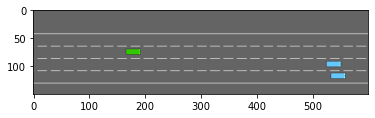

[[ 1.0000000e+00  1.0000000e+00  2.5000000e-01  2.5000000e-01
   0.0000000e+00]
 [ 1.0000000e+00  3.2652557e-01  2.5000000e-01  1.4791794e-02
  -2.2204460e-16]
 [ 1.0000000e+00  3.3427772e-01  5.0000000e-01  3.3859045e-03
   2.2204460e-16]
 [ 1.0000000e+00  3.9691263e-01 -2.5000000e-01  1.0206091e-02
   0.0000000e+00]
 [ 1.0000000e+00  5.5535179e-01  0.0000000e+00  1.8218642e-02
   0.0000000e+00]]

Acción: SLOWER -> recommpensa: 0.6888888888888892
Nuevo estado:


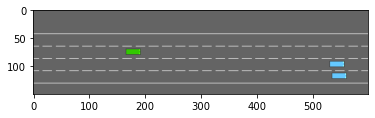

[[ 1.0000000e+00  1.0000000e+00  2.5000000e-01  2.5000000e-01
   0.0000000e+00]
 [ 1.0000000e+00  3.3240506e-01  2.5000000e-01  1.4591180e-02
  -2.2204460e-16]
 [ 1.0000000e+00  3.3565292e-01  5.0000000e-01  3.4975356e-03
   2.2204460e-16]
 [ 1.0000000e+00  4.0098765e-01 -2.5000000e-01  1.0166417e-02
   0.0000000e+00]
 [ 1.0000000e+00  5.6261265e-01  0.0000000e+00  1.8074946e-02
   0.0000000e+00]]

Acción: SLOWER -> recommpensa: 0.6888888888888892
Nuevo estado:


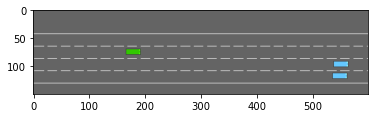

[[ 1.0000000e+00  1.0000000e+00  2.5000000e-01  2.5000000e-01
   0.0000000e+00]
 [ 1.0000000e+00  3.3707276e-01  5.0000000e-01  3.6089600e-03
   2.2204460e-16]
 [ 1.0000000e+00  3.3820304e-01  2.5000000e-01  1.4383738e-02
  -2.2204460e-16]
 [ 1.0000000e+00  4.0504688e-01 -2.5000000e-01  1.0127187e-02
   0.0000000e+00]
 [ 1.0000000e+00  5.6981474e-01  0.0000000e+00  1.7924288e-02
   0.0000000e+00]]

Acción: SLOWER -> recommpensa: 0.6888888888888892
Nuevo estado:


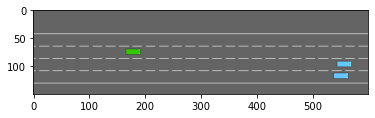

[[ 1.0000000e+00  1.0000000e+00  2.5000000e-01  2.5000000e-01
   0.0000000e+00]
 [ 1.0000000e+00  3.3853713e-01  5.0000000e-01  3.7204800e-03
   2.2204460e-16]
 [ 1.0000000e+00  3.4391680e-01  2.5000000e-01  1.4169596e-02
  -2.2204460e-16]
 [ 1.0000000e+00  4.0909049e-01 -2.5000000e-01  1.0088314e-02
   0.0000000e+00]
 [ 1.0000000e+00  5.7695526e-01  0.0000000e+00  1.7766878e-02
   0.0000000e+00]]
Episodio terminado después de 40 pasos y la recompensa fue 27.58303689028236


In [36]:
# Carga del modelo entrenado
modelo = torch.load("DQN.pth")['state_dic']
dqn.load_state_dict(modelo)

obs = env.reset()
t, total_reward, done = 0, 0, False

print("Obs inicial:")
plt.imshow(env.render(mode="rgb_array"))
plt.show()
print(obs)

while not done:
    # Obtener la acción y la ejecutamos
    action = dqn.get_action(obs, 0)
    new_obs, reward, done, info = env.step(action)
    
    # Imprimimos el paso
    print("\nAcción: {} -> recommpensa: {}".format(env.action_type.actions[action], reward))
    print("Nuevo estado:")
    plt.imshow(env.render(mode="rgb_array"))
    plt.show()
    env.close()
    print(new_obs)
    
    t += 1
    total_reward += reward
    obs = new_obs
    
print("Episodio terminado después de {} pasos y la recompensa fue {}".format(t, total_reward))